In [1]:
from neuronav.envs.hexxed_env import GridEnv, GridSize, GridObservation, GridOrientation
from neuronav.envs.graph_env import GraphEnv, GraphObservation
from neuronav.agents.td_agents import TDSR, TDQ
from neuronav.agents.dyna_agents import DynaQ, DynaSR
from neuronav.agents.mb_agents import MBV
from neuronav.envs.grid_templates import GridTemplate
from neuronav.envs.graph_templates import GraphTemplate
from neuronav.utils import run_episode, softmax, plot_values_and_policy
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'

5
4
3
2
1


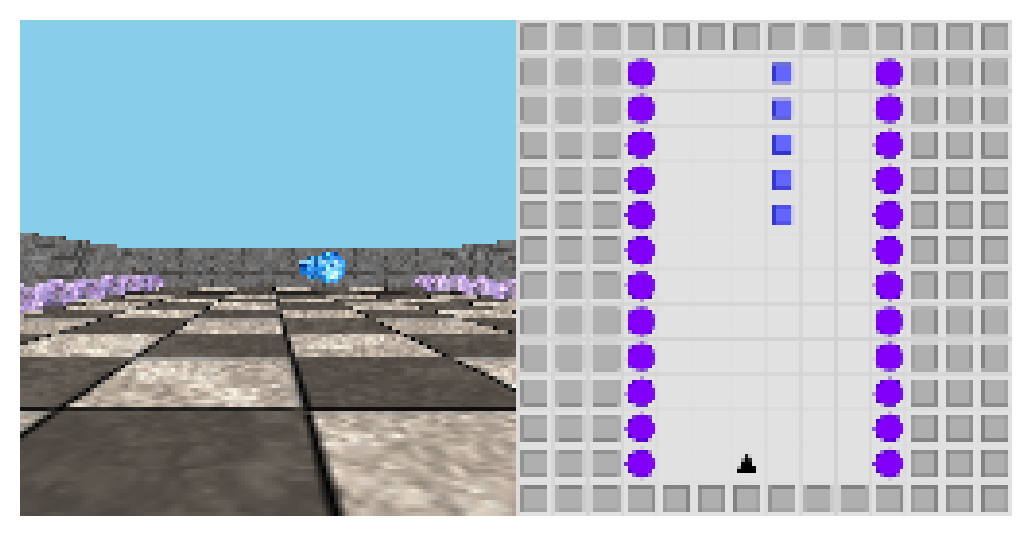

In [2]:
env = GridEnv(template=GridTemplate.hexxed, size = GridSize.hexxed, manual_collect = True, obs_type=GridObservation.rendered_3d)
obs = env.reset()

env.render()

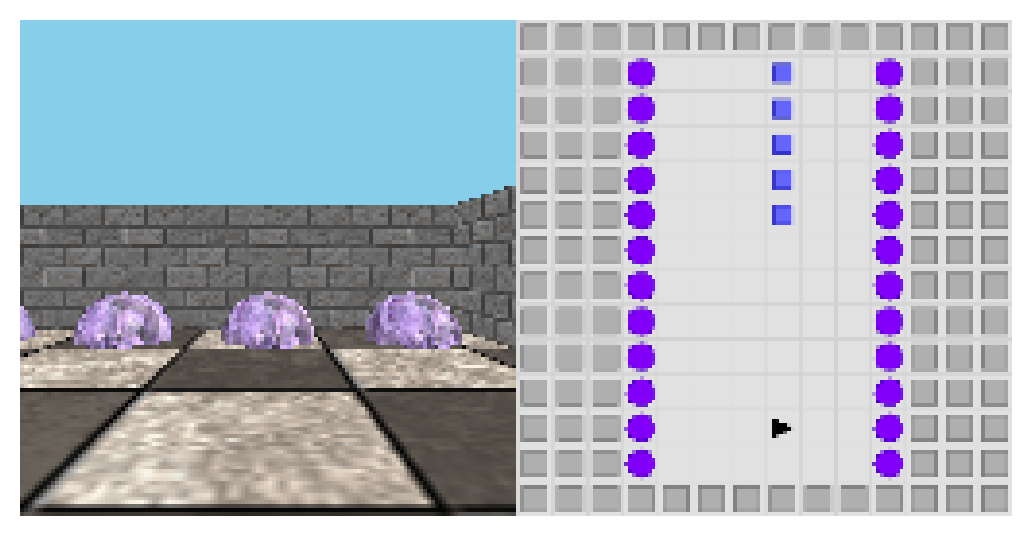

In [3]:
obs = env.step(1)
#env.agent_pos[0] = env.agent_pos[0]-1
env.render()

In [15]:
import random 

def get_randomness():
    agent_start = [12, random.randint(4, 9)]

    rewards = {}
    rwd_loc = random.randint(4, 9)
    for i in reversed(range(1,6)):
        reward = {(i, rwd_loc): i**2}
        #print(i)
        rewards.update(reward)
    return agent_start , rewards

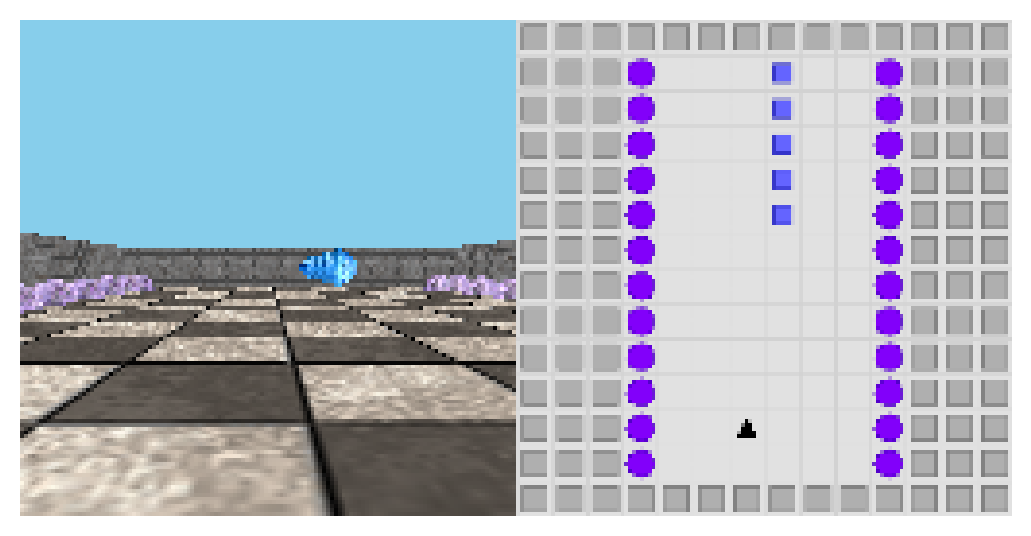

Action: 0, Reward: 0.0


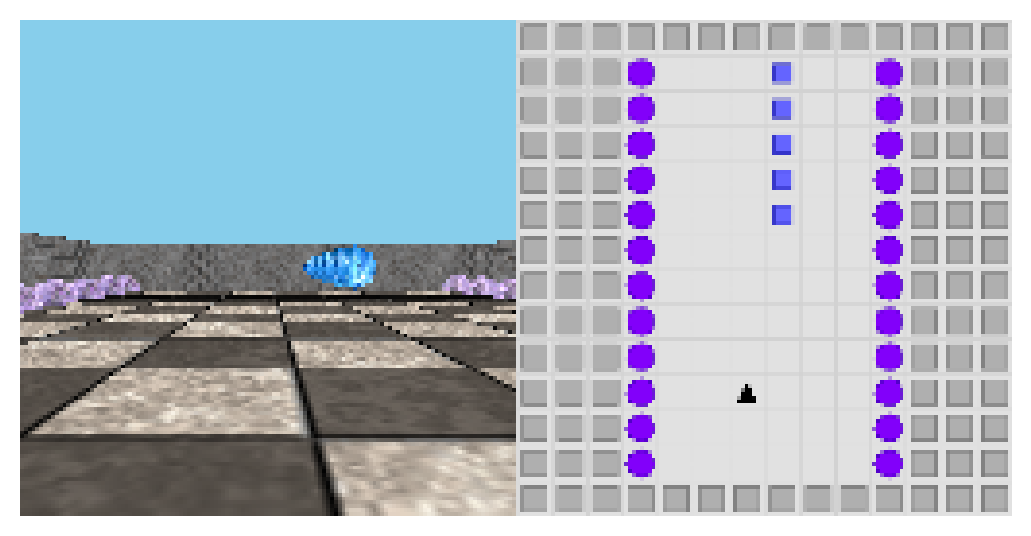

Action: 0, Reward: 0.0


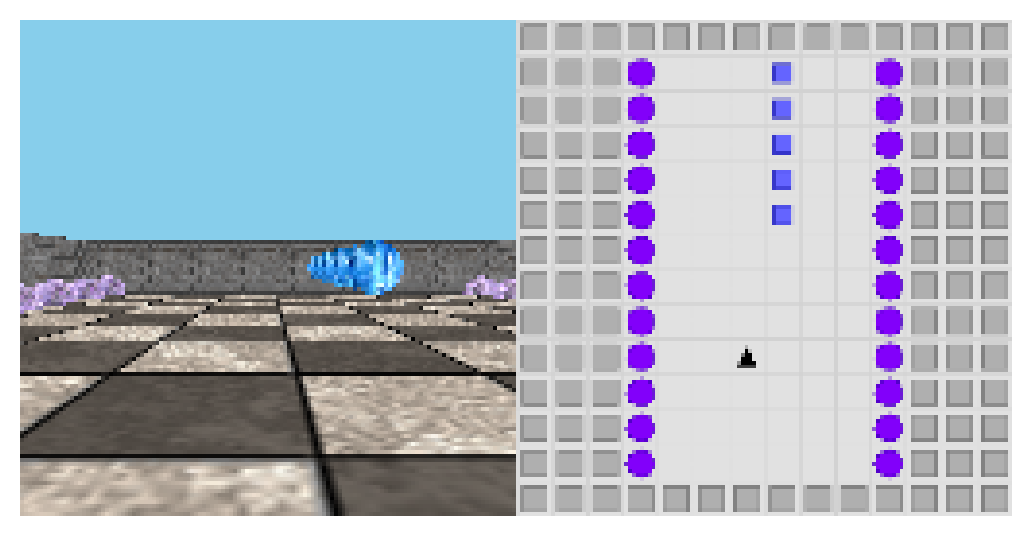

Action: 0, Reward: 0.0


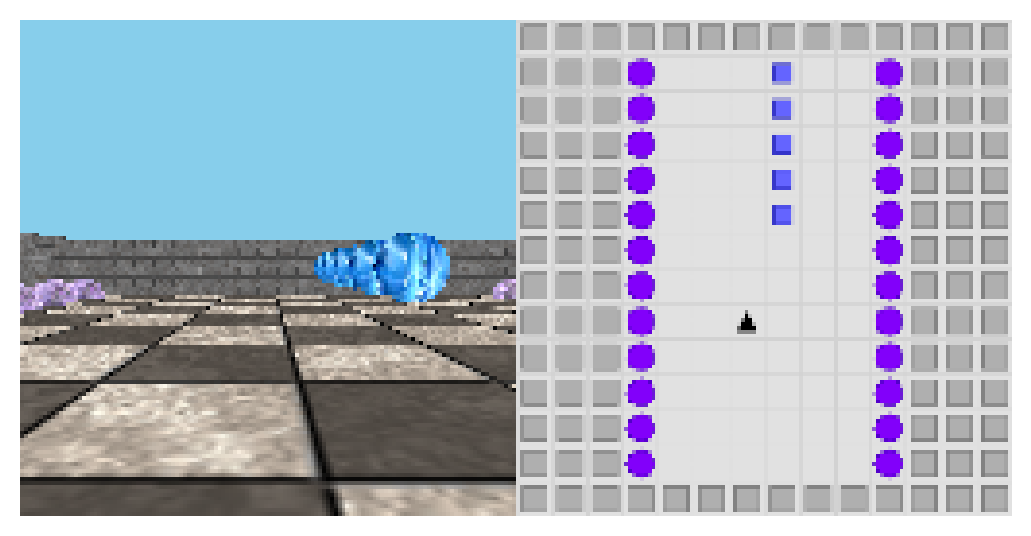

Action: 0, Reward: 0.0


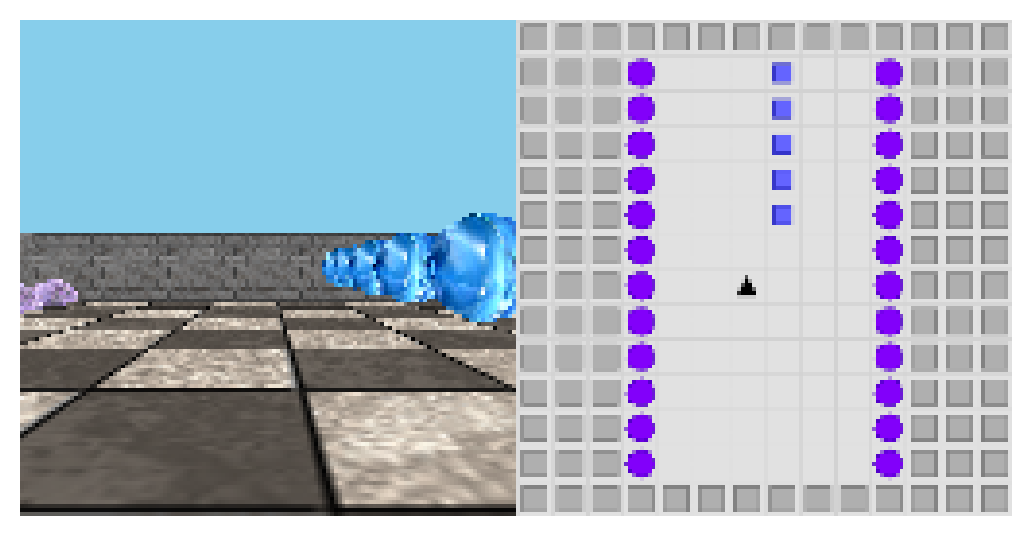

Action: 0, Reward: 0.0


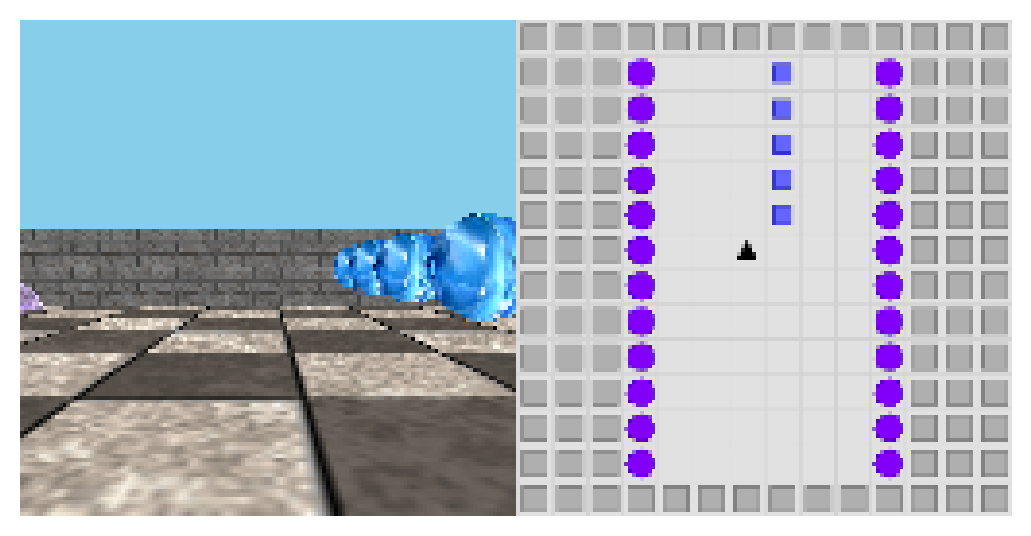

Action: 0, Reward: 0.0


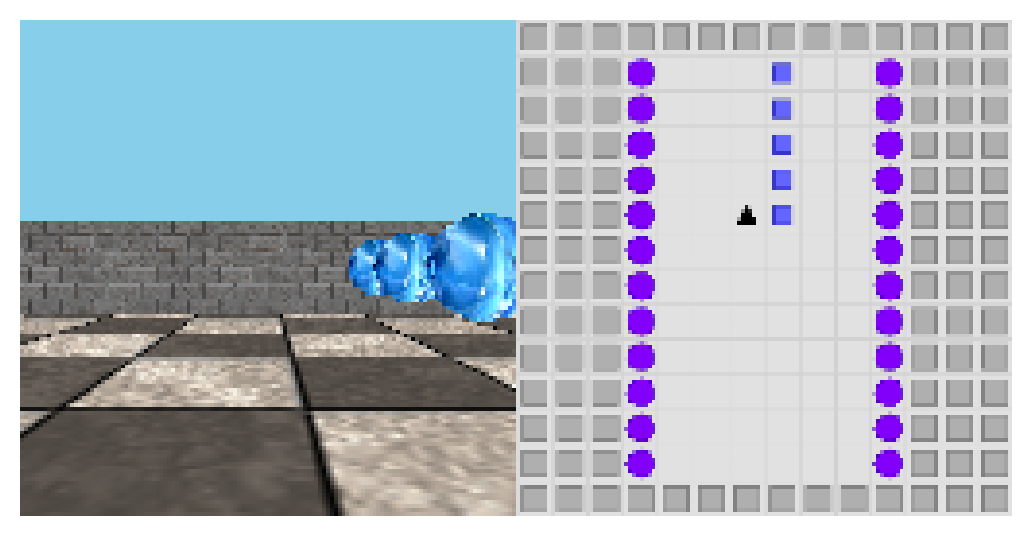

Action: 0, Reward: 0.0


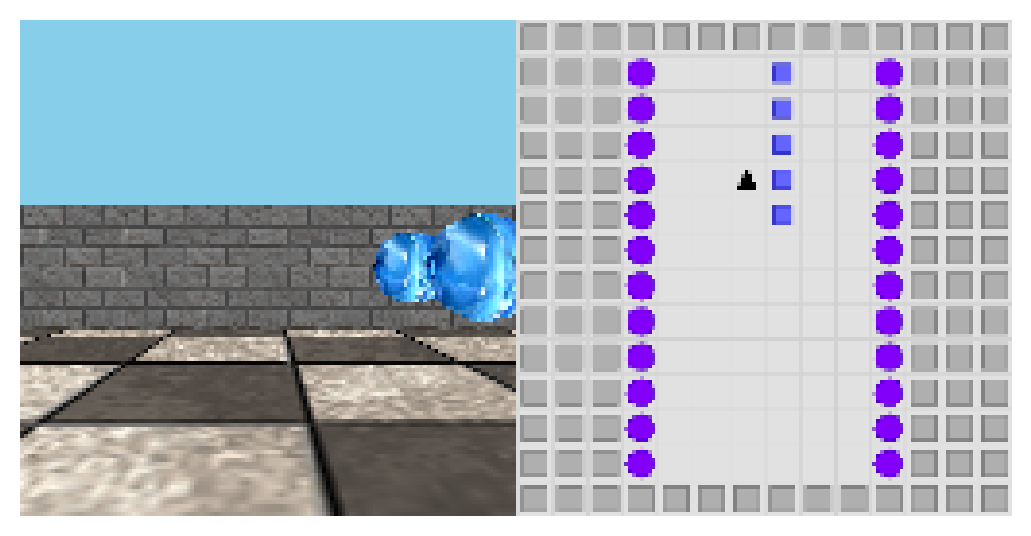

Action: 0, Reward: 0.0


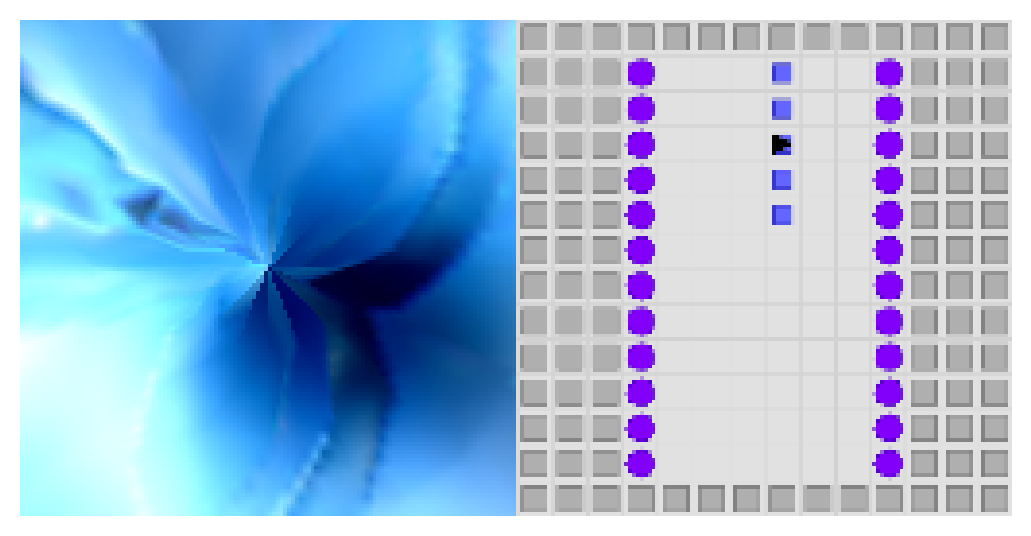

Action: 1, Reward: 0.0


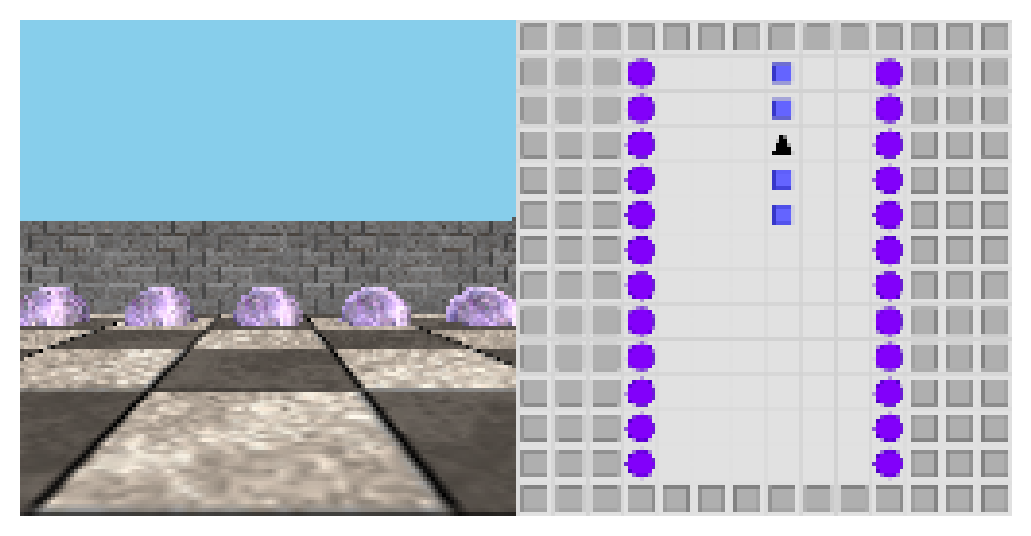

Action: 3, Reward: 9.0


In [5]:
actions = [0, 0, 0, 0,0, 0, 0,0,1,3]  # The optimal action sequence
obs = env.reset()

for idx, action in enumerate(actions):
    obs, reward, done, _ = env.step(action)
    env.render()
    print(f"Action: {action}, Reward: {reward}")

In [29]:
num_episodes = 100
num_steps = 13
lr = 5e-2
beta = 1e2

agent = TDQ(env.state_size, env.action_space.n, poltype="softmax", lr=lr, beta=beta)

episode_steps = []
for i in range(num_episodes):
    done = False
    steps = 0
    objects = {"rewards": get_randomness()[1]}
    obs = env.reset(objects = objects, agent_pos = get_randomness()[0])
    #print('episode ',i)
    while not done and steps < num_steps:
        action = agent.sample_action(obs)
        next_obs, reward, done, _ = env.step(action)
        agent.update([obs, action, next_obs, reward, done])
        obs = next_obs
        steps += 1    
        env.render()

    episode_steps.append(steps)

plt.plot(episode_steps)
_ = plt.title("Length of episodes over the course of learning")
_ = plt.ylabel("Episode steps")
_ = plt.xlabel("Episode number")
plt.gcf().set_dpi(100)
plt.show()

IndexError: index 206 is out of bounds for axis 1 with size 196

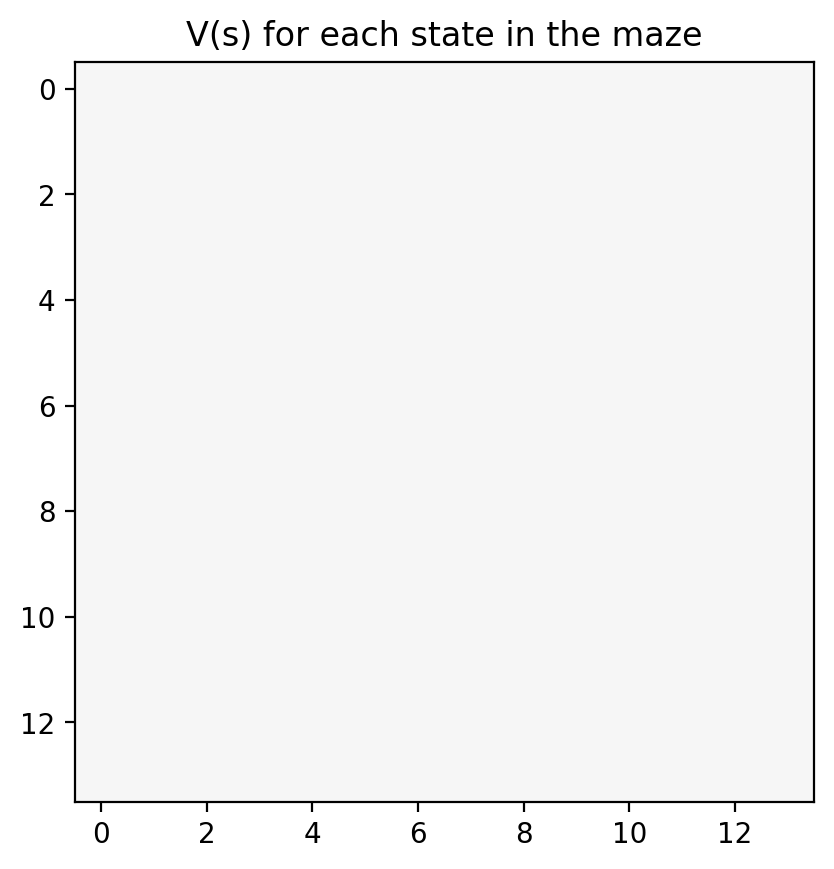

In [27]:
_ = plt.imshow(agent.Q.mean(0).reshape(14, 14), cmap="RdBu", vmin=-1, vmax=1)
_ = plt.title("V(s) for each state in the maze")

<Axes: >

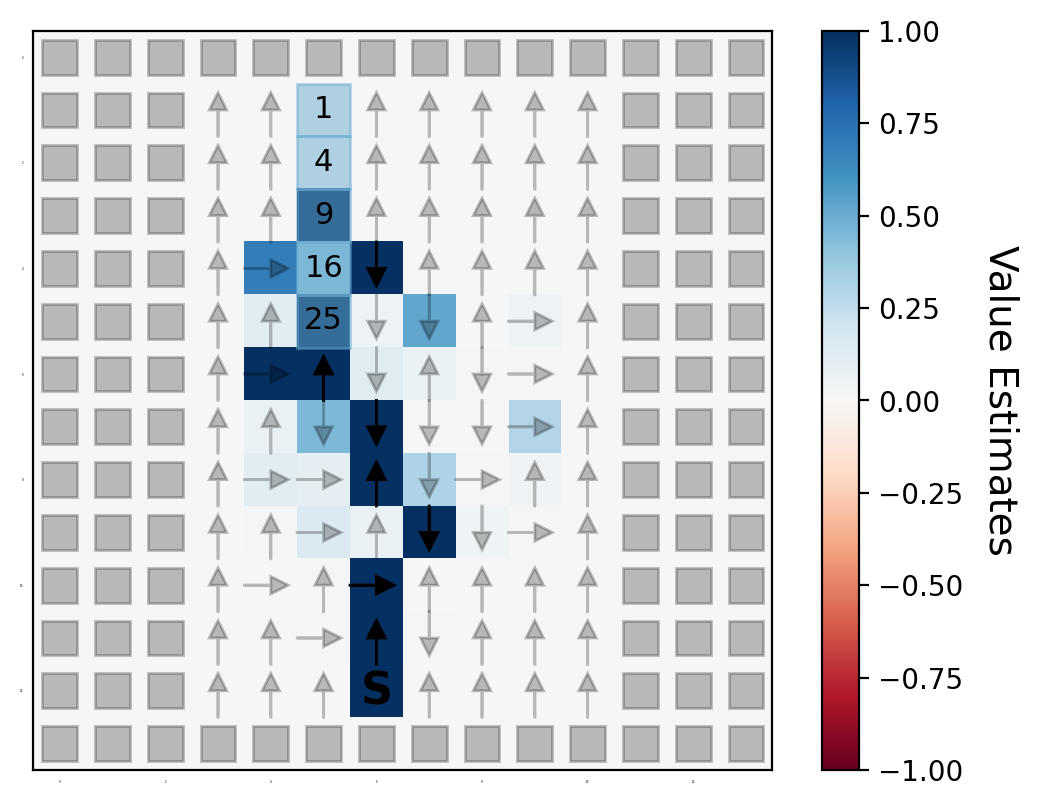

In [15]:
plot_values_and_policy(agent, env, env.agent_start_pos)

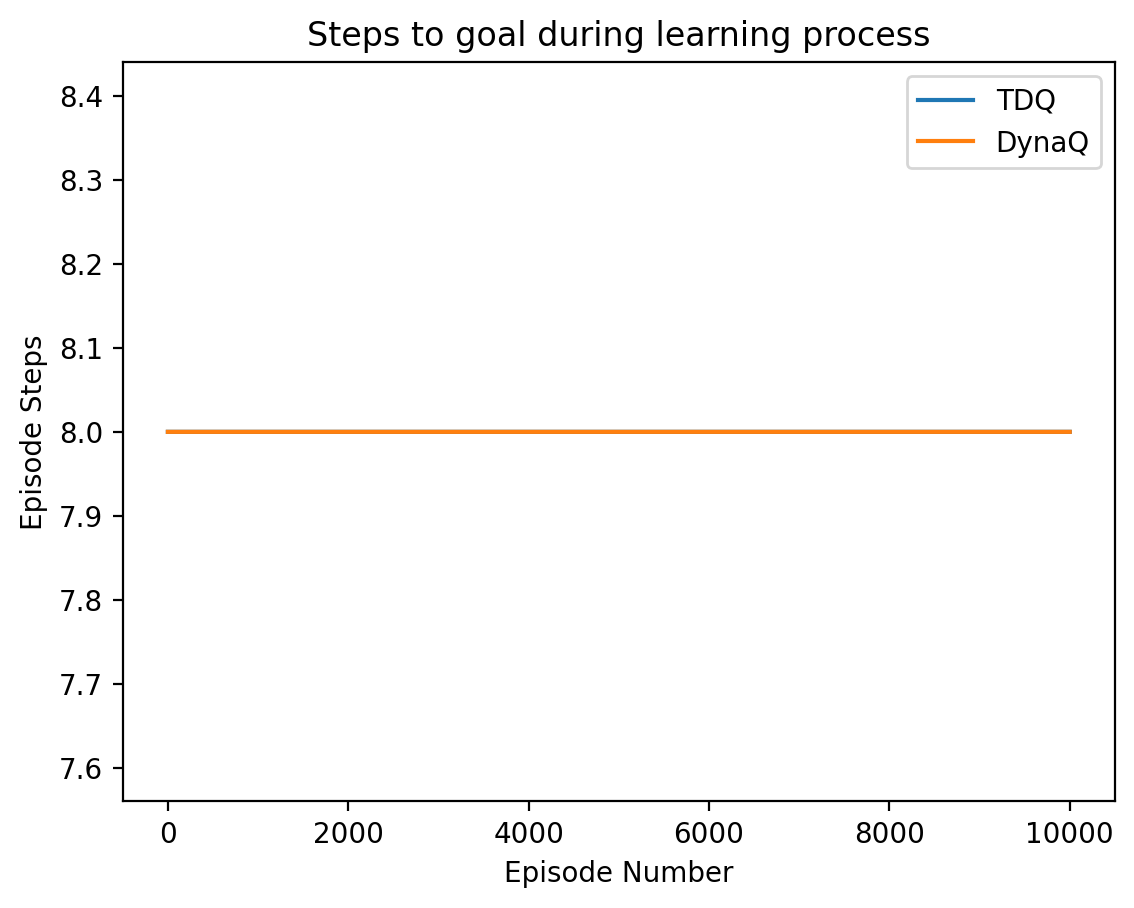

In [16]:
episode_steps = 8
num_episodes = 10000
beta = 1e2
lr = 5e-2

agent_q = TDQ(env.state_size, env.action_space.n, beta=beta, lr=lr)
agent_dq = DynaQ(env.state_size, env.action_space.n, beta=beta, lr=lr)

agents = {"TDQ": agent_q, "DynaQ": agent_dq}

for agent_name in agents:
    steps = []
    for i in range(num_episodes):
        agents[agent_name], step, _ = run_episode(
            env, agents[agent_name], episode_steps
        )
        steps.append(step)
    plt.plot(steps, label=agent_name)
plt.legend()
_ = plt.title("Steps to goal during learning process")
_ = plt.ylabel("Episode Steps")
_ = plt.xlabel("Episode Number")
plt.gcf().set_dpi(100)
plt.show()

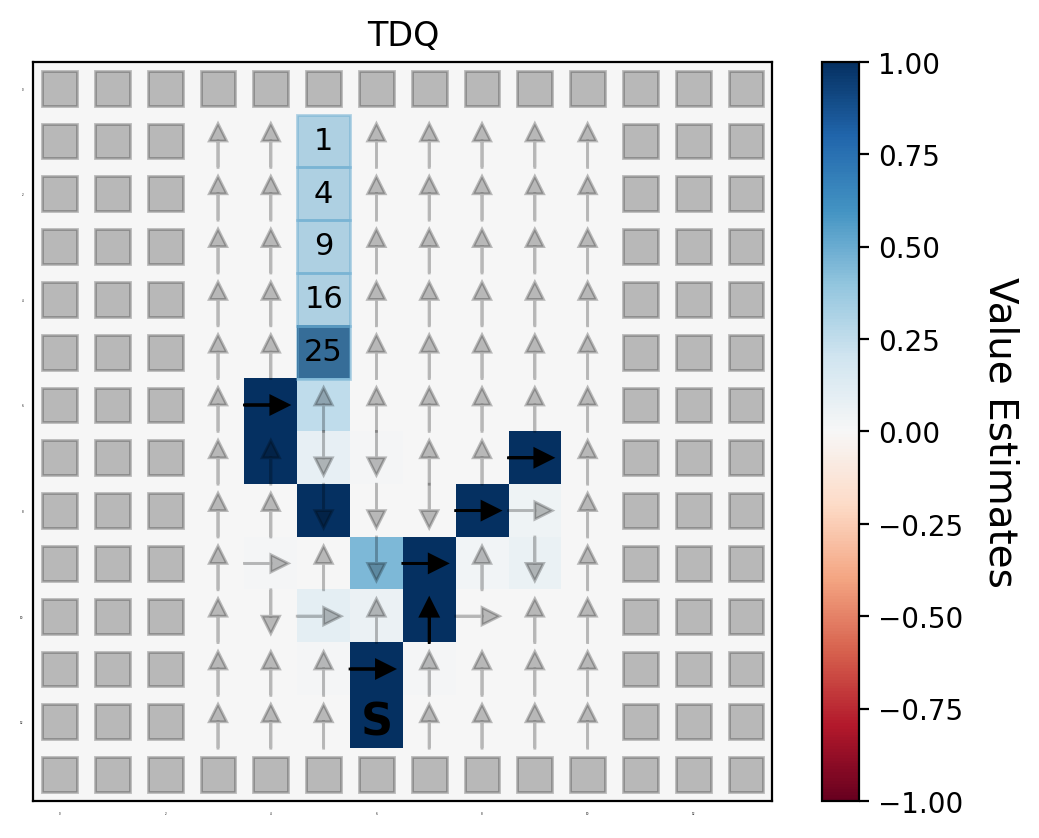

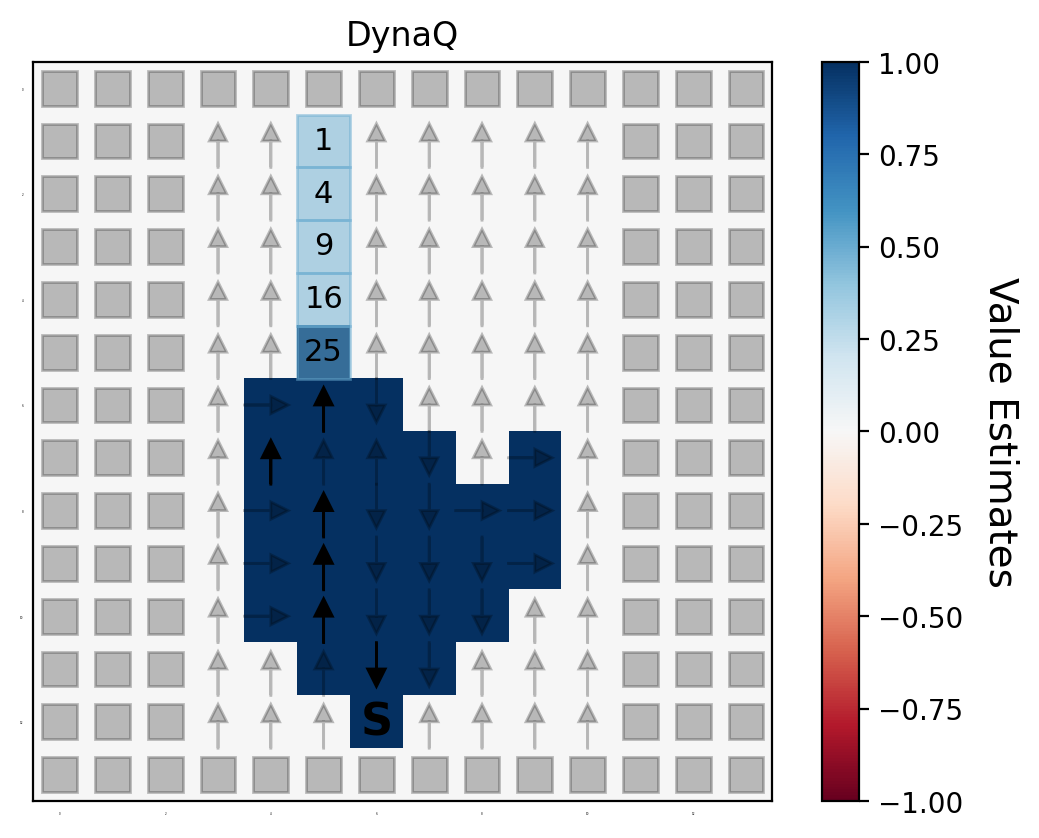

In [17]:
for agent in agents:
    plot_values_and_policy(agents[agent], env, env.agent_start_pos, plot_title=agent)